In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define data transformations (convert images to tensors & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Download MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.l2 = nn.Linear(28 * 28, 128, bias=True)  # Input: 784 → Hidden: 128
        self.l3 = nn.Linear(128, 64, bias=True)       # Hidden: 128 → Hidden: 64
        self.l4 = nn.Linear(64, 10, bias=True)        # Hidden: 64 → Output: 10

        # Unique weights for each of the 784 input activations
        self.custom_weights = nn.Parameter(torch.randn(28 * 28)) 

    def forward(self, im):
        
        l1 = im.view(-1, 28 * 28) 

        l2 = F.relu(self.l2(l1))

        l3 = torch.matmul(l2, self.l3.weight.T)
        weighted_sum = (self.custom_weights * l1).sum(dim=1) 
        l3[:, 0] += weighted_sum 
        l3 += self.l3.bias 
        l3 = F.relu(l3)

        l4 = self.l4(l3)
        
        return l4

# Initialize model
model = MNIST_Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load("model_weights-c.pth"))


<All keys matched successfully>

In [29]:
import torch.optim as optim

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

print("Training complete!")

# Save the model's state_dict
torch.save(model.state_dict(), "./model_weights-c.pth")


Epoch 1/5, Loss: 0.2921
Epoch 2/5, Loss: 0.1129
Epoch 3/5, Loss: 0.0768
Epoch 4/5, Loss: 0.2863
Epoch 5/5, Loss: 0.1769
Training complete!


In [5]:
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculations
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 96.47%


In [83]:
print(model.l2.weight.shape, model.l3.weight.shape, model.l4.weight.shape)

torch.Size([128, 784]) torch.Size([64, 128]) torch.Size([10, 64])


In [26]:
# Step 1: Get absolute values of (weight * grad)
l2 = (model.l2.weight.grad.abs() * model.l2.weight.abs())
l3 = (model.l3.weight.grad.abs() * model.l3.weight.abs())
c = (model.custom_weights.grad.abs() * model.custom_weights.abs())
l4 = (model.l4.weight.grad.abs() * model.l4.weight.abs())

# Step 2: Sum over the rows (dim=0), resulting in a tensor of shape (784,)
l1 = l2.sum(dim=0)  # Outgoing importance from l1
l2 = l3.sum(dim=0) + l2.sum(dim=1)  # Incoming + outgoing for l2
l3 = l4.sum(dim=0) + l3.sum(dim=1)  # Incoming + outgoing for l3
l3[0] = l3[0] + c.sum()  # Add custom weight importance to neuron 0
print(l3[0])
l4 = l4.sum(dim=1)  # Incoming for l4

# Step 3: Normalize by the number of connections (incoming + outgoing)
l1 = l1 / 128  # Only outgoing connections from l1
l2 = l2 / (64 + 784)  # Incoming from l1 + outgoing to l3
l3[1:] = l3[1:] / (10 + 128)  # Incoming from l2 + outgoing to l4
print(l3[1])
l3[0] = l3[0] / (10 + 128 + 784)  # Incoming + outgoing + custom weights
print(l3[0])
l4 = l4 / 10  # Only incoming connections for l4

# Print the result
print(l1.shape, l2.shape, l3.shape, l4.shape)  


tensor(0.0065, grad_fn=<SelectBackward0>)
tensor(0.0002, grad_fn=<SelectBackward0>)
tensor(7.0503e-06, grad_fn=<SelectBackward0>)
torch.Size([784]) torch.Size([128]) torch.Size([64]) torch.Size([10])


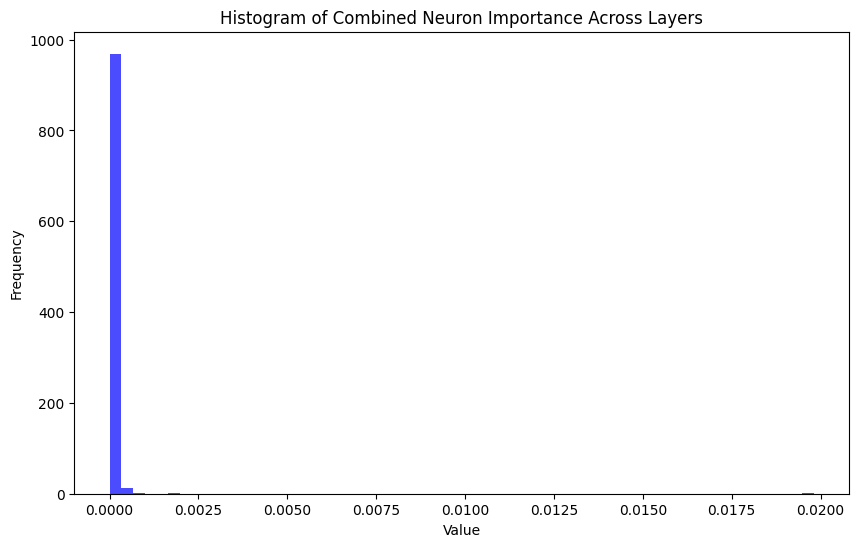

In [27]:
import matplotlib.pyplot as plt

ns = torch.cat((l1, l2, l3, l4))

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(ns.detach().numpy(), bins=60, color="blue", alpha=0.7)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Combined Neuron Importance Across Layers')

# Show the plot
plt.show()